<a href="https://colab.research.google.com/github/cemozkl123/DSA_project/blob/main/DSA_phase3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DSA Project – Phase III
## Predicting PM10 (µg/m³) Using Weather Data

In this phase, we apply supervised machine learning models to predict daily PM10 concentrations in Istanbul using meteorological and calendar-based features.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
df = pd.read_csv("/content/Istanbul_Air_Weather_Cleaned.csv")
print("Shape:", df.shape)
df.head()



Shape: (330, 14)


,Date_Key,PM10,SO2,NO2,NOX,NO,date,tavg,tmin,tmax,prcp,wspd,pres,Month
0,2024-01-03,29.62,3.30,36.60,135.43,47.63,2024-01-03,11.5,7.0,15.0,1.7,12.1,1013.2,January
1,2024-01-04,26.55,4.67,44.93,92.68,25.96,2024-01-04,12.4,10.0,15.2,0.6,11.4,1012.8,January
2,2024-01-05,31.86,2.80,44.23,156.29,67.85,2024-01-05,12.2,9.8,15.0,2.3,14.1,1015.9,January
3,2024-01-06,56.52,3.73,61.96,279.43,126.11,2024-01-06,12.5,9.0,15.0,0.0,9.1,1016.5,January
4,2024-01-07,32.73,6.51,30.39,88.86,32.92,2024-01-07,13.0,10.0,15.5,2.3,19.7,1007.6,January


## Dataset Overview

The dataset used in this phase is the cleaned and merged output from Phase 2.
It contains daily air pollution measurements and corresponding meteorological variables for Istanbul.

- Target variable: **PM10 (µg/m³)**
- Input features include temperature, precipitation, wind, pressure, and calendar-based variables.
- Each row represents one day.


In [6]:
df["Date_Key"] = pd.to_datetime(df["Date_Key"], errors="coerce")
df = df.dropna(subset=["Date_Key"]).sort_values("Date_Key").reset_index(drop=True)

df["month"] = df["Date_Key"].dt.month
df["dayofweek"] = df["Date_Key"].dt.dayofweek
df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)

# cyclic encoding (optional but nice)
doy = df["Date_Key"].dt.dayofyear
df["doy_sin"] = np.sin(2*np.pi*doy/365.25)
df["doy_cos"] = np.cos(2*np.pi*doy/365.25)

df.head()


,Date_Key,PM10,SO2,NO2,NOX,NO,date,tavg,tmin,tmax,prcp,wspd,pres,Month,month,dayofweek,is_weekend,doy_sin,doy_cos
0,2024-01-03,29.62,3.30,36.60,135.43,47.63,2024-01-03,11.5,7.0,15.0,1.7,12.1,1013.2,January,1,2,0,0.051584,0.998669
1,2024-01-04,26.55,4.67,44.93,92.68,25.96,2024-01-04,12.4,10.0,15.2,0.6,11.4,1012.8,January,1,3,0,0.068755,0.997634
2,2024-01-05,31.86,2.80,44.23,156.29,67.85,2024-01-05,12.2,9.8,15.0,2.3,14.1,1015.9,January,1,4,0,0.085906,0.996303
3,2024-01-06,56.52,3.73,61.96,279.43,126.11,2024-01-06,12.5,9.0,15.0,0.0,9.1,1016.5,January,1,5,1,0.103031,0.994678
4,2024-01-07,32.73,6.51,30.39,88.86,32.92,2024-01-07,13.0,10.0,15.5,2.3,19.7,1007.6,January,1,6,1,0.120126,0.992759


## Feature Engineering

To improve predictive performance, additional time-based features are derived from the date column.

These features help capture:
- Seasonal patterns (month)
- Weekly behavior (day of week, weekend indicator)
- Cyclical nature of the calendar (sine/cosine of day-of-year)

Such transformations are commonly used in time-series and environmental modeling.


In [7]:
target = "PM10"

feature_candidates = [
    "tavg", "tmin", "tmax", "prcp", "wspd", "pres", "wdir", "wpgt", "snow", "tsun",
    "month", "dayofweek", "is_weekend", "doy_sin", "doy_cos"
]

features = [c for c in feature_candidates if c in df.columns]
print("Using features:", features)

X = df[features]
y = df[target]


Using features: ['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres', 'month', 'dayofweek', 'is_weekend', 'doy_sin', 'doy_cos']


## Train–Test Split Strategy

A time-based split is used instead of random sampling.
The first 80% of the data is used for training, and the remaining 20% is reserved for testing.

This approach prevents data leakage and better reflects a real-world forecasting scenario,
where future values are predicted using past observations.


In [8]:
split_idx = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (264, 11) Test: (66, 11)


In [10]:
numeric_features = [c for c in features if df[c].dtype != "object"]
categorical_features = [c for c in features if df[c].dtype == "object"]

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features),
])


## Evaluation Metrics

Model performance is evaluated using the following metrics:

- **MAE (Mean Absolute Error):** Average absolute prediction error.
- **RMSE (Root Mean Squared Error):** Penalizes larger errors more heavily.
- **R² Score:** Measures how much variance in PM10 is explained by the model.

Lower MAE and RMSE indicate better performance, while higher R² values are preferred.


In [12]:
models = {
    "Dummy Mean": DummyRegressor(strategy="mean"),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01, max_iter=5000),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=5000),
    "Random Forest": RandomForestRegressor(n_estimators=400, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
}

def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

rows = []
fitted_pipelines = {}

for name, model in models.items():
    pipe = Pipeline([("preprocess", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)

    mae, rmse, r2 = evaluate(y_test, pred)
    rows.append({"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2})
    fitted_pipelines[name] = pipe

results_df = pd.DataFrame(rows).sort_values("RMSE")
results_df


,Model,MAE,RMSE,R2
4,Random Forest,9.763919,15.371010,0.311471
2,Lasso,9.098587,15.421426,0.306947
1,Ridge,8.732463,15.481910,0.301500
5,Gradient Boosting,12.258055,17.039156,0.153916
3,ElasticNet,9.973870,17.171917,0.140680
0,Dummy Mean,13.031291,18.527285,-0.000324


## Model Performance Comparison

The table above summarizes the performance of different regression models on the test set.

The Dummy Mean model provides a baseline and achieves the poorest performance, indicating that
simple averaging is insufficient to explain PM10 variability.

Among the evaluated models, **Random Forest** achieves the lowest RMSE and the highest R² score,
suggesting that non-linear relationships between meteorological variables and PM10 concentration
are present in the data.

Linear models (Ridge and Lasso) also perform reasonably well, implying that some linear structure
exists, but tree-based models are better suited to capture more complex interactions.


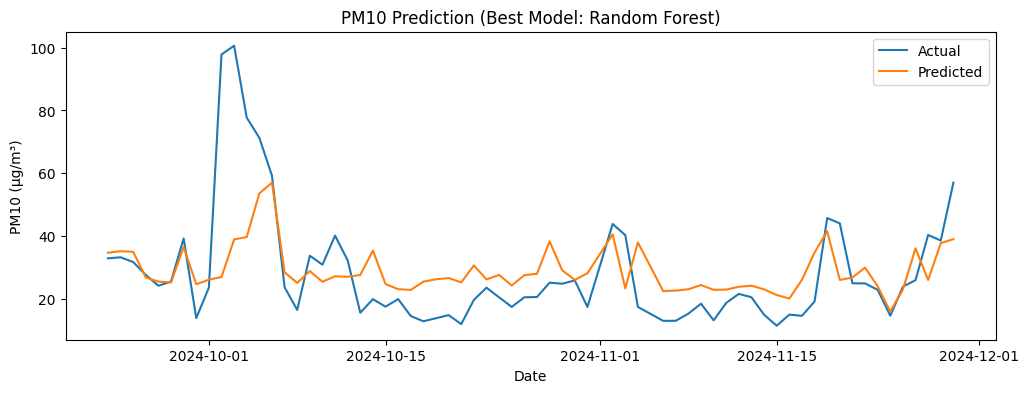

In [13]:
best_model_name = results_df.iloc[0]["Model"]
best_pipe = fitted_pipelines[best_model_name]
pred_best = best_pipe.predict(X_test)

dates_test = df["Date_Key"].iloc[split_idx:]

plt.figure(figsize=(12, 4))
plt.plot(dates_test, y_test.values, label="Actual")
plt.plot(dates_test, pred_best, label="Predicted")
plt.title(f"PM10 Prediction (Best Model: {best_model_name})")
plt.xlabel("Date")
plt.ylabel("PM10 (µg/m³)")
plt.legend()
plt.show()


## Actual vs Predicted PM10 Values

The following figure compares the true PM10 values with the predictions obtained from the
best-performing model on the test set. The plot helps visualize how well the model predicts the trends.


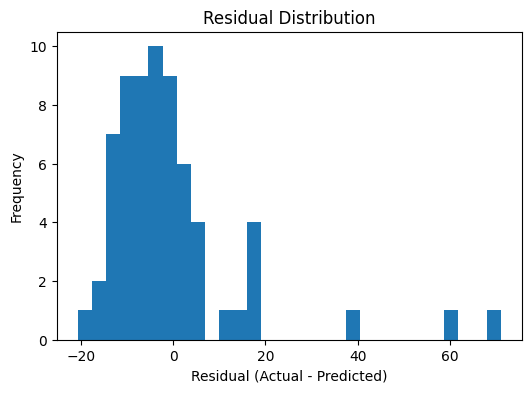

In [14]:
residuals = y_test.values - pred_best

plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30)
plt.title("Residual Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()


## Residual Analysis

The residual distribution is centered around zero, indicating that the model does not exhibit
strong systematic bias in its predictions. This suggests that overestimation and underestimation
of PM10 values occur in a relatively balanced manner.

We can see a slight right skew, with a small number of large positive residuals. These correspond
to days where actual PM10 concentrations were significantly higher than predicted, maybe because of
extreme pollution events such as traffic or industrial activity which we can not predict with the model.

Overall, the residual pattern is consistent with expectations for environmental data and
indicates that while the model performs well on average, some variability in PM10 levels remains
unexplained.


## Conclusion

In this phase, multiple machine learning models were evaluated to predict daily PM10
concentrations using the two datasets.

The results show that machine learning models clearly outperform the dummy which is my baseline,
with the Random Forest model having the best overall performance. This suggests that
non-linear interactions between weather variables play an important role in air pollution dynamics.

Future work could add lagged pollution values, longer time periods, or extreme events that occur to further improve predictive accuracy.
